# Team as an entity model

This model is a

In [155]:
# Import
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from team_dataloader import *

import numpy as np

import matplotlib.pyplot as plt
import matplotlib

In [156]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [157]:
class TeamAsEntity(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(TeamAsEntity, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM input
        # Input size: size of each element in time series
        # Hidden size: size of LSTM cell output and hidden output
        # Num layers: number of stacked LSTM cells (vertical, not horizontal). Can also use multiple explicit LSTM layers
        # (https://stackoverflow.com/questions/49224413/difference-between-1-lstm-with-num-layers-2-and-2-lstms-in-pytorch)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # midpoint betweem LSTM and output layer
        self.mid = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size),
            nn.Tanh(),
            nn.Linear(4*hidden_size, 4*input_size),
            nn.Tanh()
        )

        # Output must be same size as input (predictions for all features)
        self.out = nn.Linear(4*input_size, input_size)


    def forward(self, x):
        #https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

        # Initialize 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Device
        h0 = h0.to(device)
        c0 = c0.to(device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Select only the output of the last LSTM cycle
        out = out[:, -1, :]

        out = self.mid(out)
        out = self.out(out)
        return out
    
    """
    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.mid(output)
        output = self.out(output)
        return output, hidden
    """

# Dataset

In [158]:
# Data Paths
file = './Data/team/processed/team_data.xlsx'

# GET DESIRED FIELDS
# Season 
# Name
# Points Percentage : PTS%
# Win Percentage : Win%
# Goals For Per Game : GF/G
# Goals Against Per Game : GA/G
cols = ['team name', 'Season', 'PTS%', 'GF/G', 'GA/G']
df = pd.read_excel(file, header=0, usecols=cols)

# Remove the asterix from the team names
df = df.replace('\*', '', regex=True)

dataset = TeamDataset(df, N=5, start_season=1990, stop_season=2023)

# Dataloader

In [159]:
batch_size = 100
test_length = len(dataset)//10
train_length = len(dataset) - test_length

print(test_length)
print(train_length)
dataset_test, dataset_train = random_split(dataset, [test_length, train_length])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

63
574
(tensor([[0.4090, 2.6700, 3.4600],
        [0.3900, 2.9500, 3.6700],
        [0.4370, 2.6800, 3.3500],
        [0.4550, 2.7700, 3.3800],
        [0.4450, 2.7300, 3.2200]]), tensor([0.5240, 3.1600, 3.2900]))


# Training

In [160]:
# NOTE: N will be variable, as the input size
input_size = len(cols)-2
hidden_size = 50
model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size).to(device)

In [161]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 1500
loss_interval = 25

In [162]:
def val_epoch(model, dataloader, loss):
  val_losses = []

  for idx,batch in enumerate(dataloader): # for each validation batch

    x, y = batch[0].to(device), batch[1].to(device)

    preds = model(x)

    val_loss = loss(preds, y)
    val_losses.append(val_loss.item())

  return val_losses

In [163]:
N=5 # TODO: change dataloader dynamically based on multiple N. Create a list of dataloader and mix-n-match the N accross batches

#training loop
# initialize the hidden state.
#hidden = (torch.zeros(1, batch_size, hidden_size))

train_losses = []
val_losses = []

for i in range(epochs): # for each epoch
    for idx,batch in enumerate(dataloader_train): # for each batch

        x, y = batch[0].to(device), batch[1].to(device)

        # clear gradients
        model.zero_grad()

        # predict
        #y_pred, hidden = model(batch[0], hidden)
        y_pred = model(x)

        # get loss
        loss = criterion(y_pred, y)

        # propagate and train
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        print(i,"th epoch : ", loss.item())

    # Validation and losses
    if i%loss_interval == 0:
        vlosses = val_epoch(model, dataloader_test, criterion)
        val_losses += vlosses
        train_losses.append(loss.item())
        print(f"Validation loss for epoch {i}: {vlosses}")


0 th epoch :  2.384129762649536
Validation loss for epoch 0: [2.4322965145111084]
Validation loss for epoch 25: [1.0918052196502686]
50 th epoch :  0.7148034572601318
Validation loss for epoch 50: [0.7578839659690857]
Validation loss for epoch 75: [0.5896340608596802]
100 th epoch :  0.38347795605659485
Validation loss for epoch 100: [0.46738219261169434]
Validation loss for epoch 125: [0.3899034559726715]
150 th epoch :  0.3173808157444
Validation loss for epoch 150: [0.3533335328102112]
Validation loss for epoch 175: [0.34051474928855896]
200 th epoch :  0.32024312019348145
Validation loss for epoch 200: [0.33665260672569275]
Validation loss for epoch 225: [0.33556681871414185]
250 th epoch :  0.3113093674182892
Validation loss for epoch 250: [0.3352462351322174]
Validation loss for epoch 275: [0.3352147042751312]
300 th epoch :  0.3478431701660156
Validation loss for epoch 300: [0.3351704478263855]
Validation loss for epoch 325: [0.335126131772995]
350 th epoch :  0.3147594928741455

# Plot Results

In [195]:

def plot_train_v_loss(train_loss, val_loss):
    """
    Plots the train VS loss curves

    train_loss: list of losses during training
    val_loss: list of validation losses

    NOTE: train_loss and val_loss must be the same size

    """
    #@title
    f, axs = plt.subplots(1,1, figsize=(15,5))
    font = {'size' : 14}
    matplotlib.rc('font', **font)

    axs = (axs, 0)

    xticks = np.arange(0, epochs, step=loss_interval)

    axs[0].plot(xticks, train_loss, lw=3, ms=8, marker='o',
            color='orange', label='Train')
    axs[0].set_title("Train/Val Loss")
    axs[0].set_ylabel("Loss")
    axs[0].plot(xticks, val_loss, lw=3, ms=10, marker='^',
            color='purple', label='Validation')
    
    axs[0].set_title('Team-as-entity\nTrain/Val Loss Over Time')
    axs[0].set_xlabel("Epochs")
    #axs[0].set_ylim(0,max(train_loss+val_loss))
    axs[0].set_ylim(max(0, min(train_losses+val_losses)-0.1), min(np.mean(train_losses+val_losses)+0.2, max(train_losses+val_losses)))
    axs[0].axhline(len(val_losses), lw=3, ls='--', c='#5a9520', label='Test')
    axs[0].grid()

    plt.legend()
    plt.show()

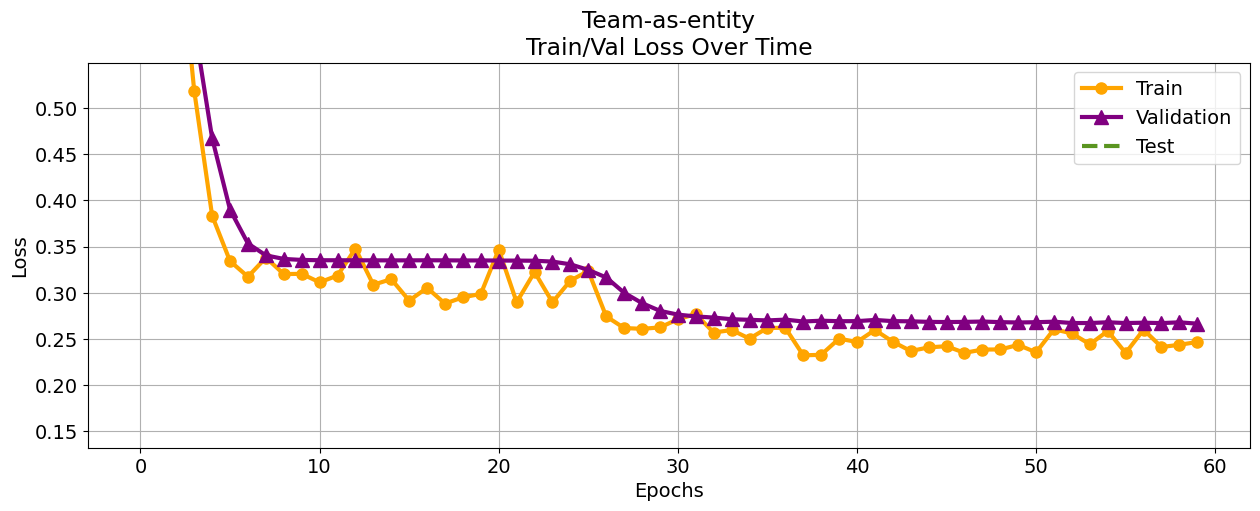

In [196]:
plot_train_v_loss(train_losses, val_losses)